## Multilabel 

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras as K
import matplotlib.cm as cm
from tqdm import tqdm
from pathlib import Path
from keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from tensorflow import keras
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

Filename                  Label
0        image_1.jpg       [Kerbau,Manusia]
1       image_10.jpg       [Kerbau,Manusia]
2      image_100.jpg               [Kerbau]
3      image_101.jpg       [Kerbau,Manusia]
4      image_102.jpg       [Kerbau,Manusia]
...              ...                    ...
2110  image_1999.jpg  [Kerbau,Manusia,Truk]
2111     image_2.jpg       [Kerbau,Manusia]
2112    image_20.jpg       [Kerbau,Manusia]
2113   image_200.jpg               [Kerbau]
2114  image_2000.jpg               [Kerbau]

[2115 rows x 2 columns]

In [3]:
# buat daftar unique dari semua label
unique_label = set()
for label in df["Label"]:
    label_list = label.strip("[]").split(",")
    for label in label_list:
        unique_label.add(label.strip())

unique_label = sorted(list(unique_label))
# buatkan kolom one-hot encodinf setiap label
for label in unique_label:
    df[label] = df["Label"].apply(lambda x: int(label in x))

In [4]:
df.head()

Filename             Label  Hewan liar  Kerbau  Manusia  Motor  Truk
0    image_1.jpg  [Kerbau,Manusia]           0       1        1      0     0
1   image_10.jpg  [Kerbau,Manusia]           0       1        1      0     0
2  image_100.jpg          [Kerbau]           0       1        0      0     0
3  image_101.jpg  [Kerbau,Manusia]           0       1        1      0     0
4  image_102.jpg  [Kerbau,Manusia]           0       1        1      0     0

In [5]:
len(df)

2115

In [6]:
df["Filename"] = "data/image/" + df["Filename"] 

<Axes: xlabel='Label'>

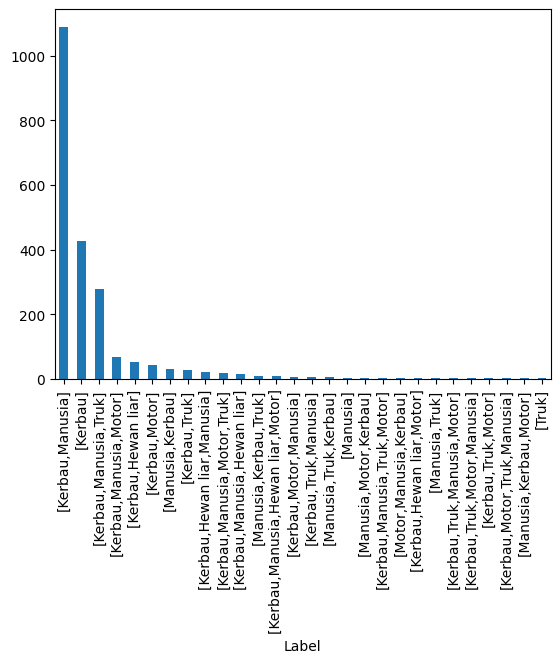

In [7]:
df['Label'].value_counts().plot(kind='bar')

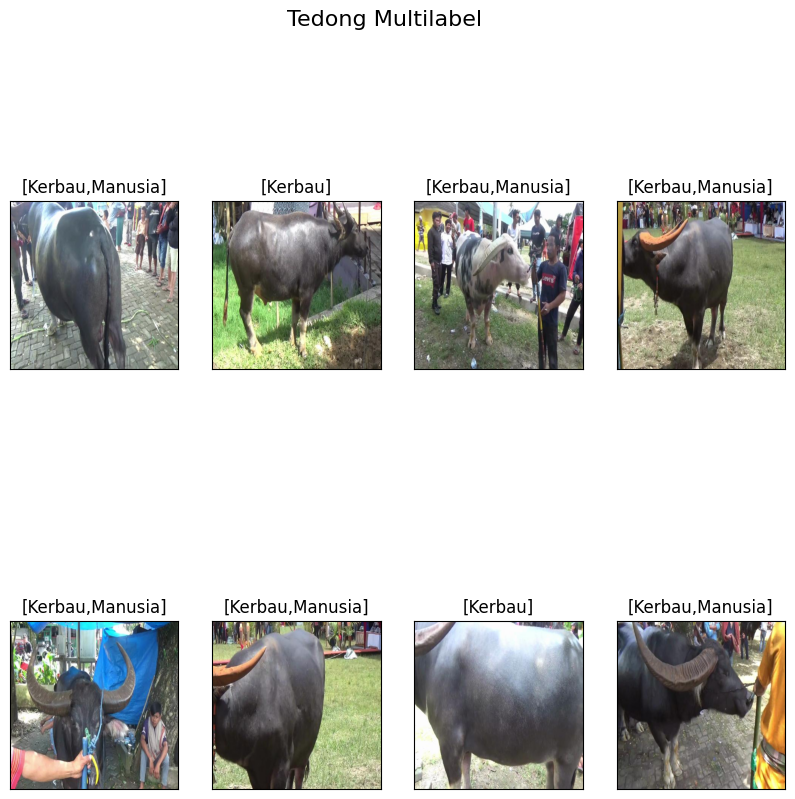

In [8]:
random_index = np.random.randint(0, len(df), 10)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filename[random_index[i]]))
    ax.set_title(df.Label[random_index[i]])
fig.suptitle("Tedong Multilabel", fontsize=16)
plt.show()
fig.savefig("tedong.png")

In [9]:
# df.drop(columns='Label', axis=1, inplace=True)
# df

In [10]:
train, test = train_test_split(df, test_size=0.05, random_state=42)

In [11]:
train = train.drop(columns="Label", axis=1)
train

Filename  Hewan liar  Kerbau  Manusia  Motor  Truk
1239  data/image/image_1210.jpg           0       1        1      0     1
1818  data/image/image_1734.jpg           0       1        1      0     1
1630  data/image/image_1563.jpg           0       1        1      0     0
582    data/image/image_573.jpg           0       1        1      0     0
368    data/image/image_430.jpg           1       1        0      0     0
...                         ...         ...     ...      ...    ...   ...
1638  data/image/image_1570.jpg           0       1        1      1     0
1095  data/image/image_1081.jpg           0       1        1      0     1
1130  data/image/image_1112.jpg           0       1        1      0     0
1294  data/image/image_1260.jpg           0       1        1      0     1
860    data/image/image_854.jpg           0       1        1      0     0

[2009 rows x 6 columns]

In [12]:
test = test.drop(columns="Label", axis=1)
test

Filename  Hewan liar  Kerbau  Manusia  Motor  Truk
1617  data/image/image_1551.jpg           0       1        1      0     0
1471   data/image/image_142.jpg           0       1        1      0     0
259    data/image/image_332.jpg           0       1        1      0     0
432    data/image/image_489.jpg           0       1        0      0     0
1506  data/image/image_1451.jpg           0       1        1      0     0
...                         ...         ...     ...      ...    ...   ...
1876  data/image/image_1787.jpg           0       1        1      0     0
1690  data/image/image_1617.jpg           0       1        1      0     0
1709  data/image/image_1634.jpg           0       1        1      0     0
1483  data/image/image_1430.jpg           0       1        1      0     0
2107  data/image/image_1996.jpg           0       1        1      0     0

[106 rows x 6 columns]

In [13]:
classes = ["Hewan liar","Kerbau","Manusia","Motor","Truk"]

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
train_gen = train_datagen.flow_from_dataframe(train, 
                                            x_col='Filename', 
                                            y_col=classes,
                                            target_size=(224,224),
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            subset='training')
val_gen = train_datagen.flow_from_dataframe(train,
                                            x_col='Filename',
                                            y_col=classes,
                                            target_size=(224,224),
                                            class_mode='raw',
                                            batch_size=16,
                                            subset='validation')

Found 1608 validated image filenames.
Found 401 validated image filenames.


In [15]:
test_gen = test_datagen.flow_from_dataframe(test,
                                            x_col='Filename',
                                            y_col=classes,
                                            batch_size=1,
                                            shuffle=None,
                                            seed=42,
                                            target_size=(224,224),
                                            class_mode="raw")

Found 106 validated image filenames.


## Metrics

In [16]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives =K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = ["accuracy", 
           tf.keras.metrics.Recall(),
           tf.keras.metrics.Precision(),
           f1_score]

## Callback

In [17]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs", datetime.datetime.now().strftime(f"%Y-%m-%d-{name}"))
    return TensorBoard(logdir)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.9):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.accuracy:
            print(f"\nAkurasi telah mencapai {self.accuracy}%")
            self.model.stop_training = True

## Plot Model

In [18]:
def plot_model(model, name_model):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,
                                     ncols=1,
                                     figsize=(15, 15))
        ax1.plot(model.history["accuracy"], marker=".")
        ax1.plot(model.history["recall"], marker=".") 
        ax1.plot(model.history["precision"], marker=".")
        ax1.plot(model.history["f1_score"], marker=".")
        ax1.set_xlabel("epochs")
        ax1.legend(["accuracy", 
        "recall", 
        "precission", 
        "f1"], loc="lower left")
        ax1.grid(True)
        ax1.set_title(name_model + ' Training')
        
        ax2.plot(model.history["val_accuracy"], marker=".")
        ax2.plot(model.history["val_recall"], marker=".") 
        ax2.plot(model.history["val_precision"], marker=".")
        ax2.plot(model.history["val_f1_score"], marker=".")
        ax2.set_xlabel("epochs")
        ax2.legend(["val_accuracy", 
                "val_recall", 
                "val_precission", 
                "val_f1"], loc="lower left")
        ax2.grid(True)
        ax2.set_title(name_model + " Val")
        
        ax3.plot(model.history["loss"])
        ax3.plot(model.history["val_loss"])
        ax3.set_xlabel("epochs")
        ax3.legend(["loss", 'val_loss'])
        ax3.grid(True)
        ax3.set_title(name_model + " Loss")
        fig.suptitle(name_model, fontsize=24)
        return plt.show

## Predict

In [19]:
def predict(model, name_file):
    test_gen.reset()
    pred = model.predict(test_gen,steps=test_gen.n // test_gen.batch_size, verbose=1)
    pred_bool = (pred > 0.5)
    predictions = pred_bool.astype(int)
    columns=classes
    #columns should be the same order of y_col
    results = pd.DataFrame(predictions, columns=columns)
    results["Filenames"] = test_gen.filenames
    ordered_cols=["Filenames"]+columns
    results=results[ordered_cols]
    return results.to_csv(name_file, index=False)
    

## visual confusion matrix

In [20]:
y_true = test[classes]

In [21]:
def visaul_confusion_matrix(y_true, y_pred):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    print(mcm)
# Display confusion matrices for each class
    for i in range(len(classes)):
        disp = ConfusionMatrixDisplay(confusion_matrix=mcm[i], display_labels=[0, 1])
        disp.plot(cmap='viridis', values_format='d')
        plt.title(f'Confusion Matrix for {classes[i]}')
    return plt.show()
        

# Model

In [22]:
def model(pre_trained_model, last_layer):
    x = tf.keras.layers.Flatten()(last_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    return model

### Resnet50

In [23]:
def resnet50():
    pre_trained_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3),
                                                                include_top=False,
                                                                weights='imagenet')
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    return pre_trained_model 

In [24]:
resnet50 = resnet50()
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [25]:
last_layer_resnet50 = resnet50.get_layer("conv5_block3_out")
last_output_resnet50 = last_layer_resnet50.output

In [26]:
model_resnet50 = model(resnet50, last_output_resnet50)
model_resnet50.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [27]:
with tf.device("/device:GPU:0"):
        histori1 = model_resnet50.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resnet50")])

Epoch 1/30
50/50 [==============================] - 10s 91ms/step - loss: 1.1009 - accuracy: 0.8433 - recall: 0.7881 - precision: 0.8013 - f1_score: 0.7901 - val_loss: 0.3417 - val_accuracy: 0.9400 - val_recall: 0.7874 - val_precision: 0.9419 - val_f1_score: 0.8572
Epoch 2/30
50/50 [==============================] - 4s 71ms/step - loss: 0.3053 - accuracy: 0.9372 - recall: 0.8285 - precision: 0.8807 - f1_score: 0.8539 - val_loss: 0.2716 - val_accuracy: 0.9325 - val_recall: 0.8406 - val_precision: 0.8747 - val_f1_score: 0.8572
Epoch 3/30
50/50 [==============================] - 4s 71ms/step - loss: 0.2820 - accuracy: 0.9321 - recall: 0.8360 - precision: 0.8896 - f1_score: 0.8597 - val_loss: 0.2751 - val_accuracy: 0.9400 - val_recall: 0.8297 - val_precision: 0.8938 - val_f1_score: 0.8608
Epoch 4/30
50/50 [==============================] - 4s 71ms/step - loss: 0.2667 - accuracy: 0.9499 - recall: 0.8414 - precision: 0.8976 - f1_score: 0.8690 - val_loss: 0.2517 - val_accuracy: 0.9400 - val_r

<function matplotlib.pyplot.show(close=None, block=None)>

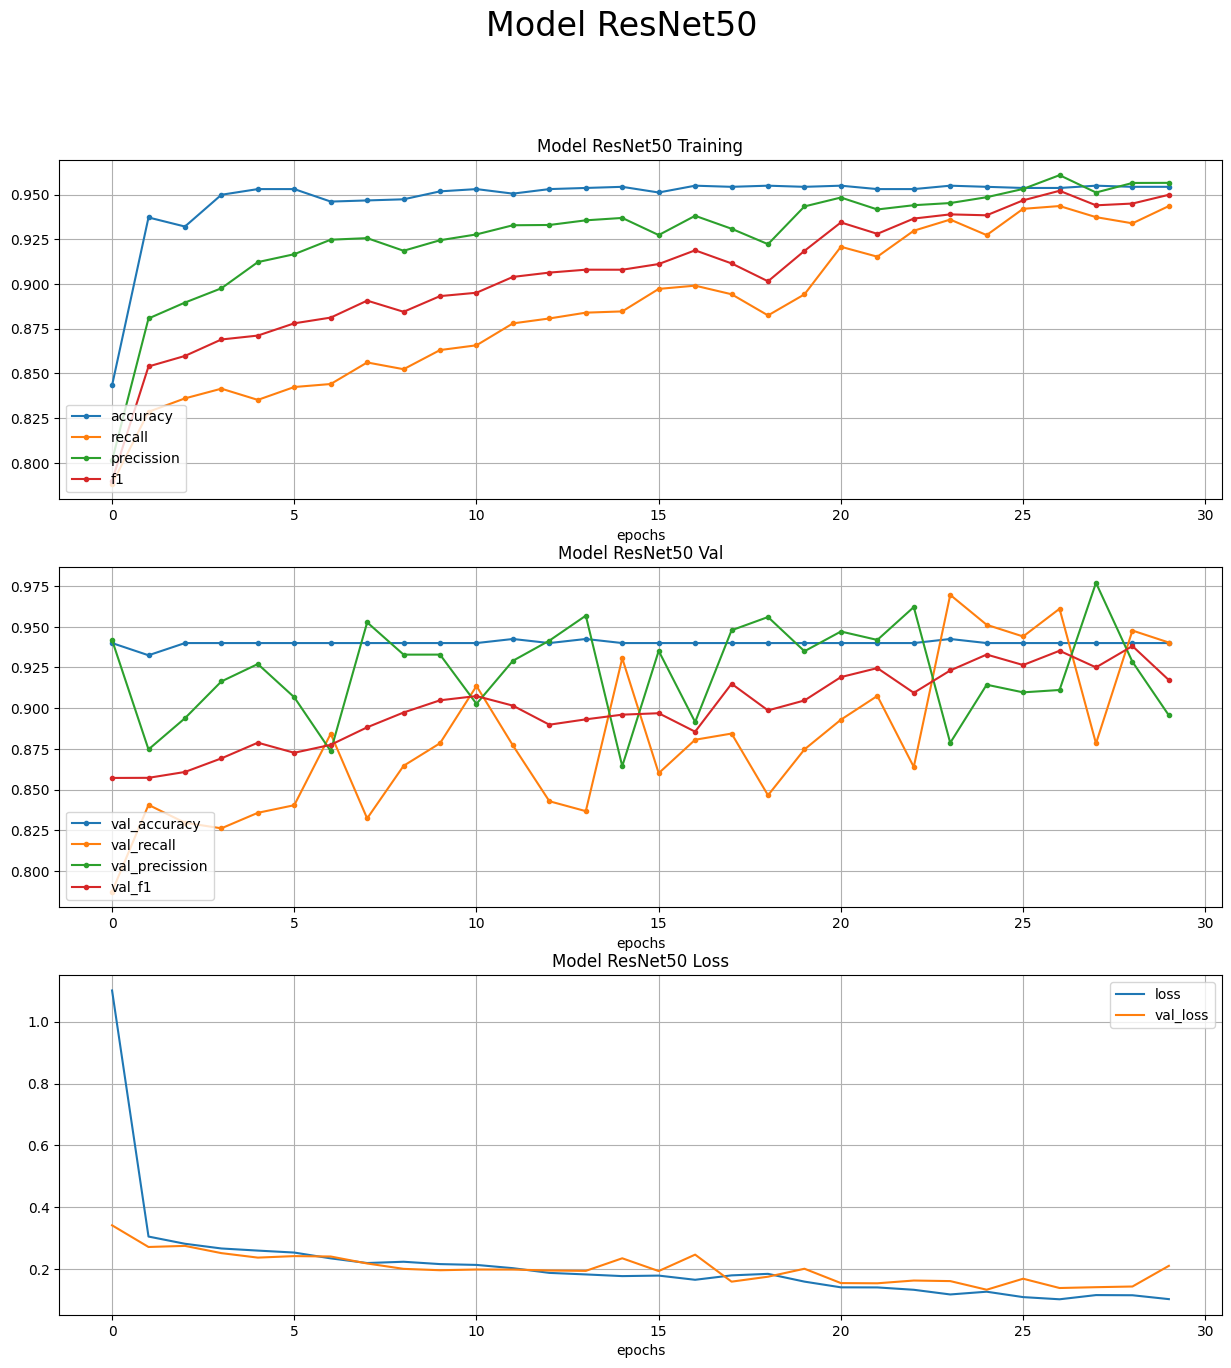

In [28]:
plot_model(histori1, "Model ResNet50")

In [29]:
model_resnet50.evaluate(test_gen, steps=train_gen.n // train_gen.batch_size)

50/50 [==============================] - 1s 18ms/step - loss: 0.2651 - accuracy: 1.0000 - recall: 0.9388 - precision: 0.8762 - f1_score: 0.9111


[0.26512610912323,
 1.0,
 0.9387755393981934,
 0.8761904835700989,
 0.911142885684967]

In [30]:
predict(model_resnet50, "model resNet50.csv")
dt_model_resnet50 = pd.read_csv("model resNet50.csv")


106/106 [==============================] - 3s 15ms/step


[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 14  17]
  [  0  75]]

 [[ 97   0]
  [  6   3]]

 [[ 81   7]
  [  4  14]]]


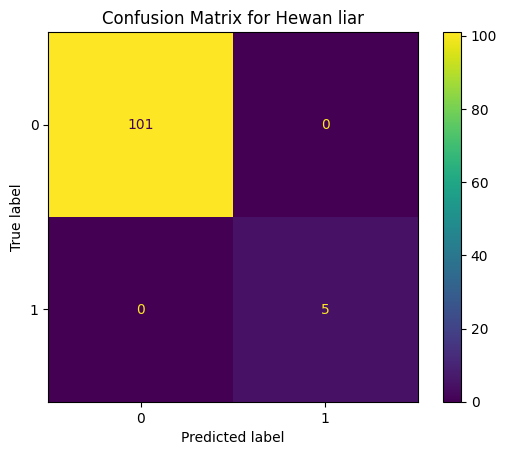

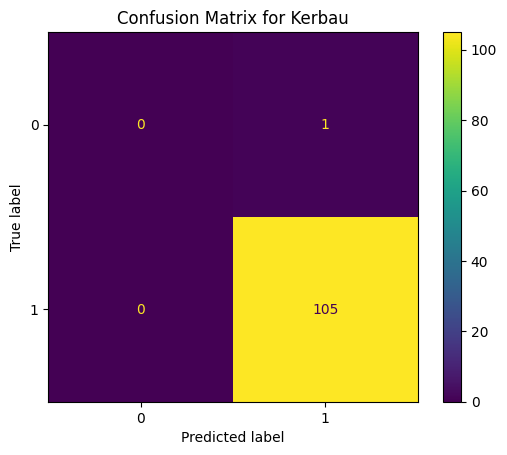

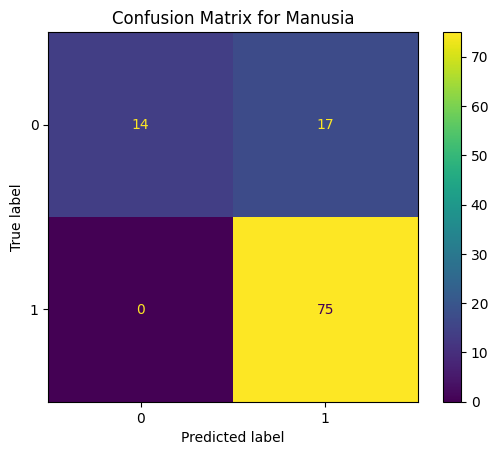

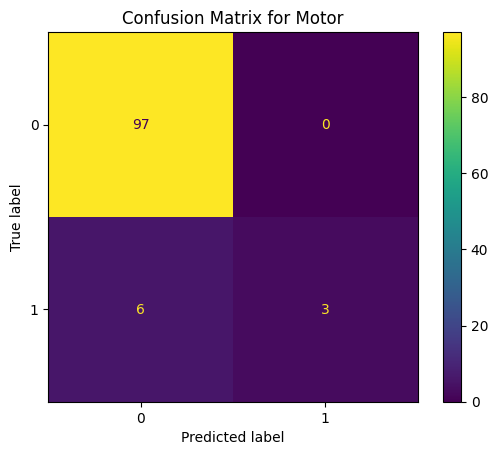

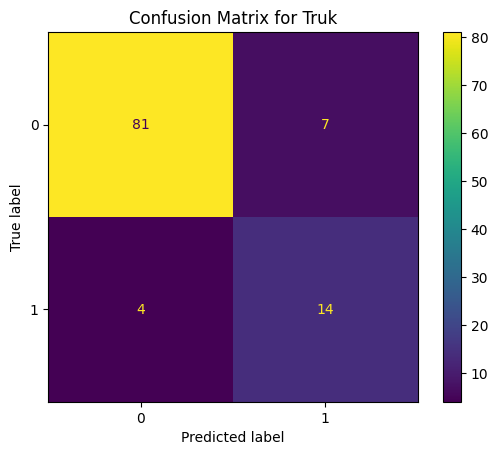

In [31]:
y_pred_resnet50 = dt_model_resnet50[classes]
visaul_confusion_matrix(y_true, y_pred_resnet50)

### Resnet50V2

In [32]:
def resnet50V2():
    pre_trained_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
    
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    return pre_trained_model

In [33]:
resnet50V2 = resnet50V2()

In [34]:
resnet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [35]:
last_layer_resnet50V2 = resnet50V2.get_layer("post_relu")
last_output_resnet50V2 = last_layer_resnet50V2.output

In [37]:
model_resNet50V2 = model(resnet50V2, last_output_resnet50V2)
model_resNet50V2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resNet50V2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [38]:
with tf.device("/device:GPU:0"):
        histori2 = model_resNet50V2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resNet50V2")])

Epoch 1/30
50/50 [==============================] - 8s 90ms/step - loss: 2.4127 - accuracy: 0.8902 - recall: 0.8639 - precision: 0.8621 - f1_score: 0.8613 - val_loss: 0.2973 - val_accuracy: 0.8950 - val_recall: 0.9233 - val_precision: 0.9451 - val_f1_score: 0.9335
Epoch 2/30
50/50 [==============================] - 3s 69ms/step - loss: 0.2702 - accuracy: 0.7938 - recall: 0.9467 - precision: 0.9446 - f1_score: 0.9460 - val_loss: 0.2882 - val_accuracy: 0.7425 - val_recall: 0.9501 - val_precision: 0.9342 - val_f1_score: 0.9424
Epoch 3/30
50/50 [==============================] - 3s 69ms/step - loss: 0.1282 - accuracy: 0.8280 - recall: 0.9625 - precision: 0.9616 - f1_score: 0.9626 - val_loss: 0.2399 - val_accuracy: 0.9050 - val_recall: 0.9380 - val_precision: 0.9662 - val_f1_score: 0.9530
Epoch 4/30
50/50 [==============================] - 3s 69ms/step - loss: 0.1031 - accuracy: 0.8420 - recall: 0.9751 - precision: 0.9727 - f1_score: 0.9736 - val_loss: 0.3614 - val_accuracy: 0.8050 - val_re

<function matplotlib.pyplot.show(close=None, block=None)>

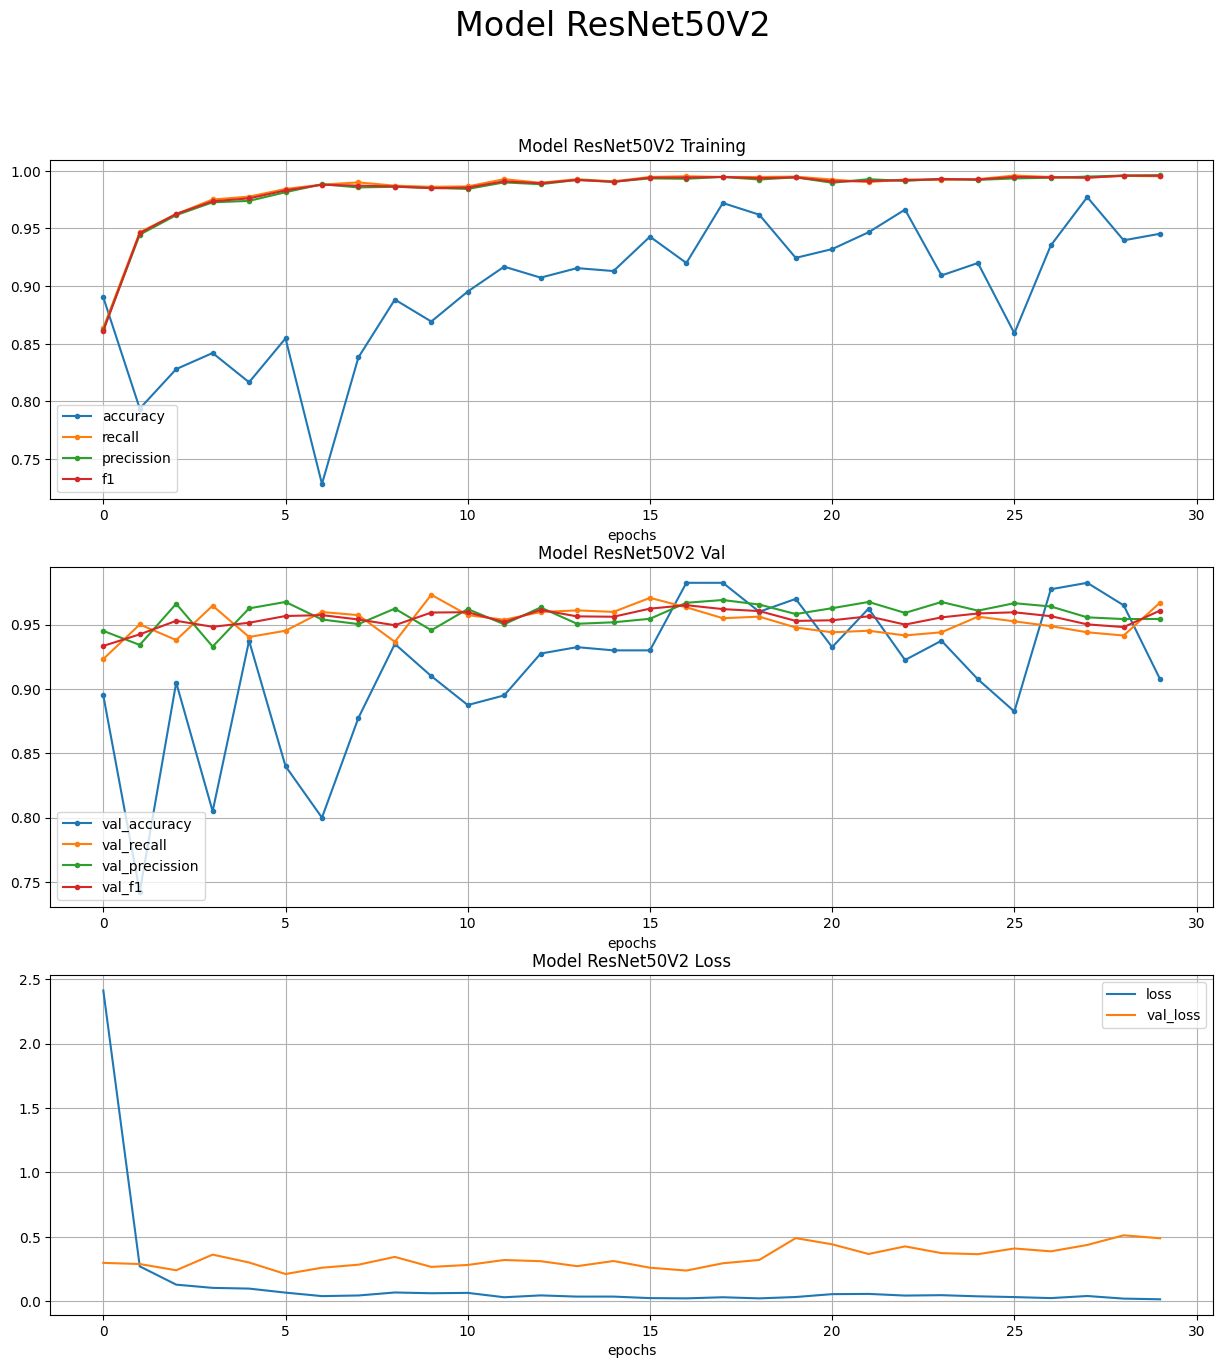

In [39]:
plot_model(histori2, "Model ResNet50V2")

In [40]:
model_resNet50V2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 2s 17ms/step - loss: 0.3307 - accuracy: 0.9245 - recall: 0.9623 - precision: 0.9401 - f1_score: 0.9525


[0.33073094487190247,
 0.9245283007621765,
 0.9622641801834106,
 0.940092146396637,
 0.952515721321106]

In [41]:
predict(model_resNet50V2, "model resNet50V2.csv")

106/106 [==============================] - 2s 13ms/step


In [42]:
dt_predict_resnet50V2 = pd.read_csv("model resNet50V2.csv")

In [43]:
y_pred_resnet50V2 = dt_predict_resnet50V2[classes]

[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 25   6]
  [  2  73]]

 [[ 97   0]
  [  2   7]]

 [[ 82   6]
  [  4  14]]]


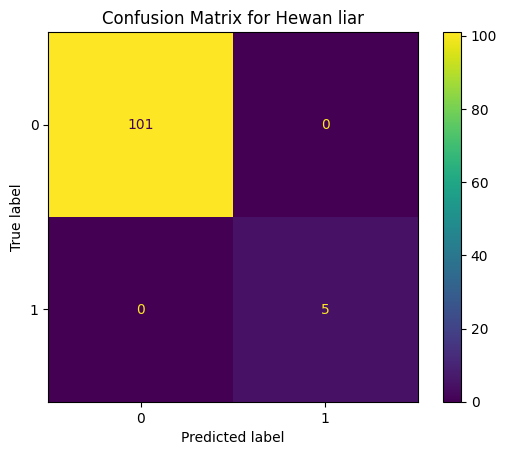

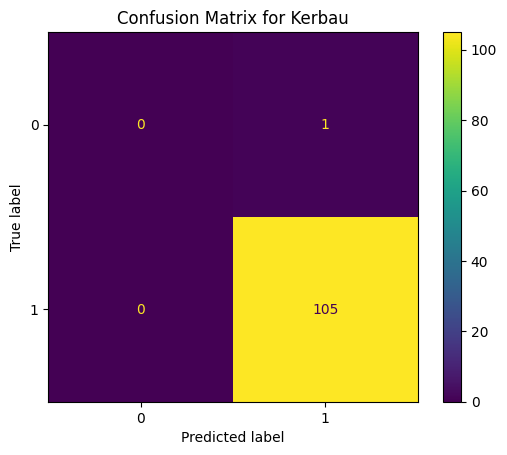

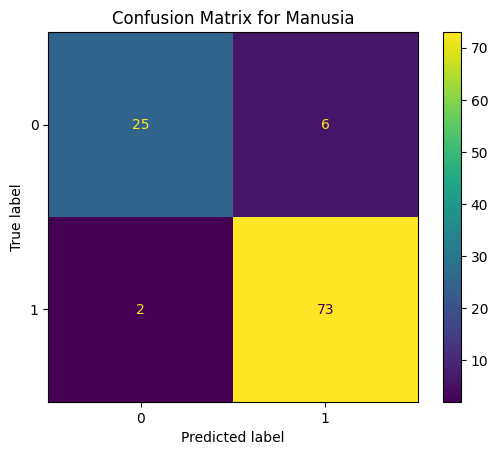

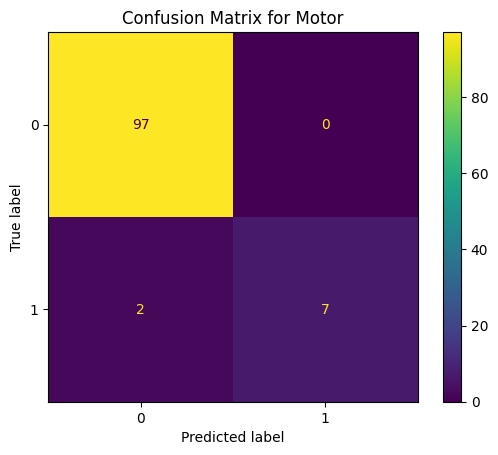

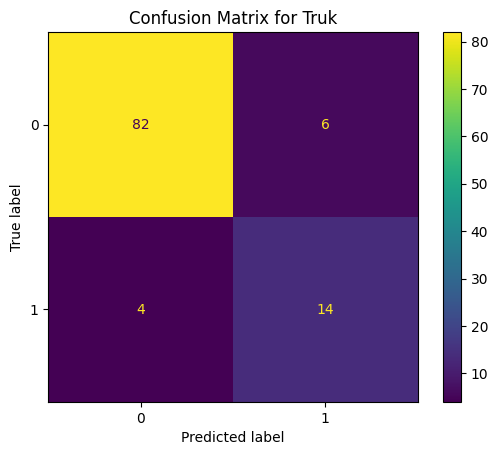

In [44]:
visaul_confusion_matrix(y_true, y_pred_resnet50V2)

### Resnet101v2

In [45]:
def resnet101v2():
    pre_train = tf.keras.applications.resnet_v2.ResNet101V2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )
    
    for layer in pre_train.layers:
        layer.trainable = False
        
    return pre_train

In [46]:
resnet101v2 = resnet101v2()
resnet101v2.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [47]:
last_layer_resnet101V2 = resnet101v2.get_layer("post_relu")
last_output_resnet101V2 = last_layer_resnet101V2.output

In [48]:
model_resNet101V2 = model(resnet101v2, last_output_resnet101V2)
model_resNet101V2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resNet101V2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [49]:
with tf.device("/device:GPU:0"):
        histori3 = model_resNet101V2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resNet101V2")])

Epoch 1/30
50/50 [==============================] - 11s 110ms/step - loss: 2.1114 - accuracy: 0.9156 - recall: 0.8720 - precision: 0.8653 - f1_score: 0.8616 - val_loss: 0.2678 - val_accuracy: 0.9200 - val_recall: 0.9040 - val_precision: 0.9442 - val_f1_score: 0.9240
Epoch 2/30
50/50 [==============================] - 4s 77ms/step - loss: 0.2450 - accuracy: 0.8598 - recall: 0.9395 - precision: 0.9449 - f1_score: 0.9425 - val_loss: 0.2279 - val_accuracy: 0.9350 - val_recall: 0.9477 - val_precision: 0.9570 - val_f1_score: 0.9523
Epoch 3/30
50/50 [==============================] - 4s 77ms/step - loss: 0.1271 - accuracy: 0.8807 - recall: 0.9704 - precision: 0.9677 - f1_score: 0.9677 - val_loss: 0.1913 - val_accuracy: 0.9025 - val_recall: 0.9647 - val_precision: 0.9318 - val_f1_score: 0.9481
Epoch 4/30
50/50 [==============================] - 4s 78ms/step - loss: 0.0836 - accuracy: 0.9086 - recall: 0.9789 - precision: 0.9740 - f1_score: 0.9769 - val_loss: 0.1643 - val_accuracy: 0.9250 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

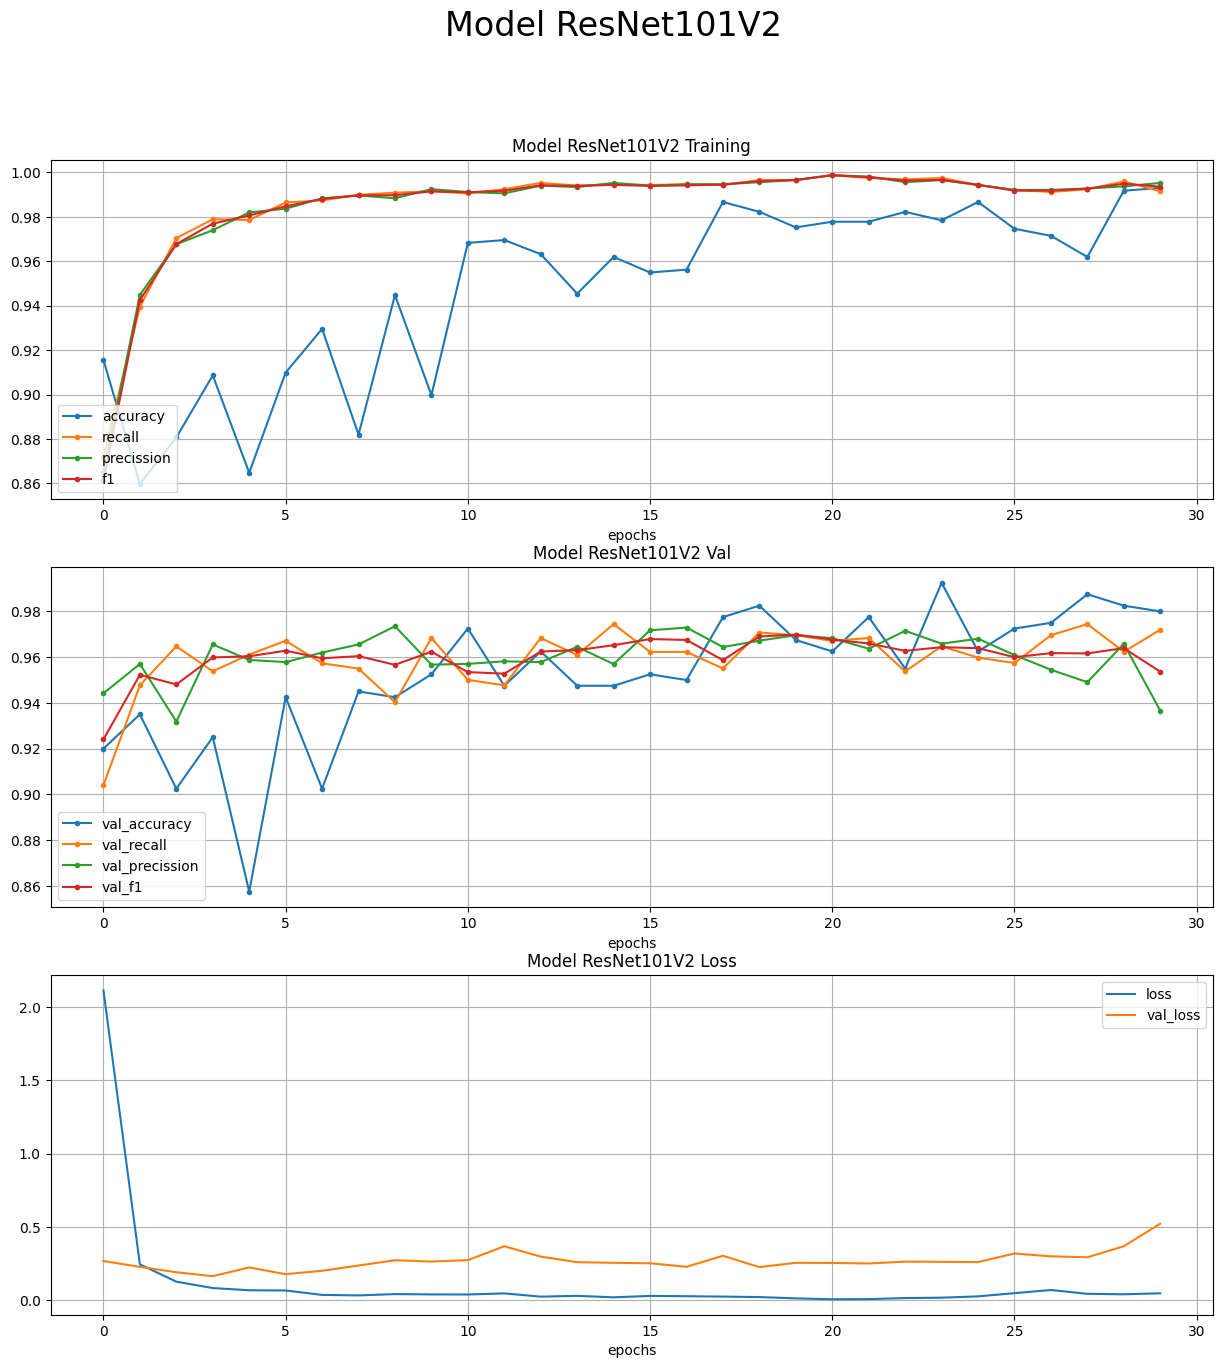

In [50]:
plot_model(histori3, "Model ResNet101V2")

In [51]:
model_resNet101V2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 3s 29ms/step - loss: 0.5275 - accuracy: 0.9906 - recall: 0.9670 - precision: 0.9234 - f1_score: 0.9480


[0.5275411605834961,
 0.9905660152435303,
 0.9669811129570007,
 0.9234234094619751,
 0.9480234384536743]

In [52]:
predict(model_resNet101V2, "model resNet101V2.csv")

106/106 [==============================] - 4s 25ms/step


In [53]:
dt_predict_resnet101V2 = pd.read_csv("model resNet101V2.csv")

In [54]:
y_pred_resnet101V2 = dt_predict_resnet101V2[classes]

[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 23   8]
  [  1  74]]

 [[ 94   3]
  [  1   8]]

 [[ 83   5]
  [  5  13]]]


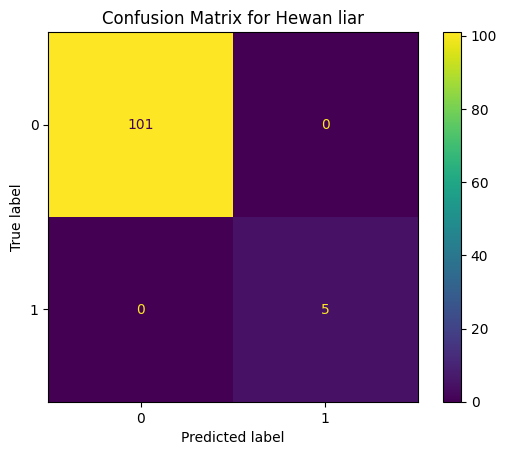

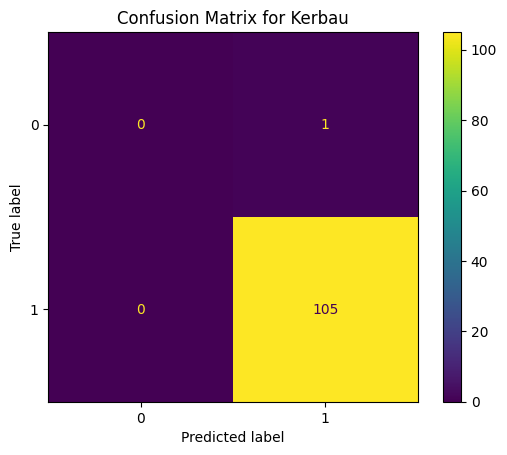

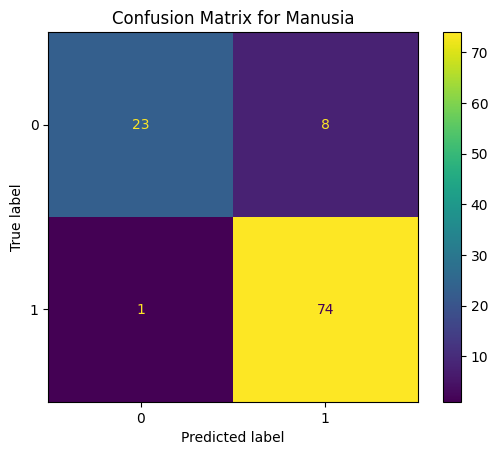

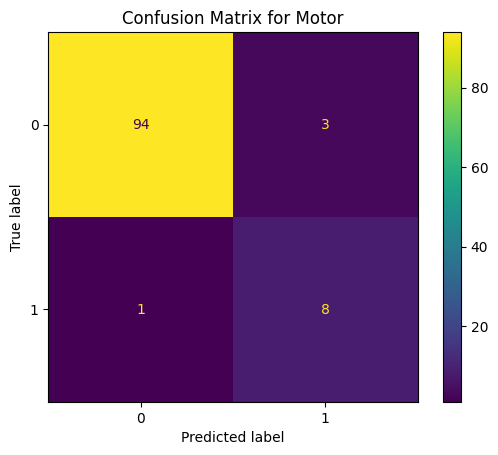

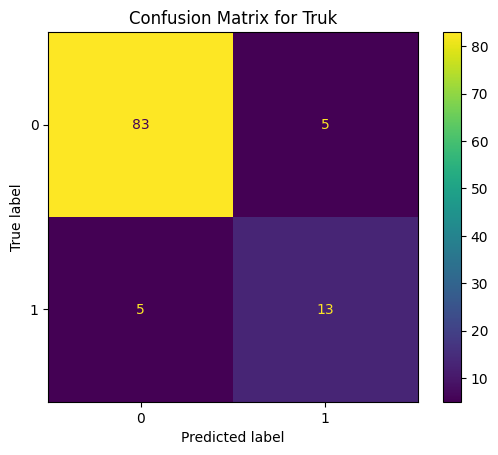

In [55]:
visaul_confusion_matrix(y_true, y_pred_resnet101V2)

### Resnet152v2

In [56]:
def resnet152v2():
    pre_trained = tf.keras.applications.resnet_v2.ResNet152V2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )
    
    for layer in pre_trained.layers:
        layer.trainable = False
        
    return pre_trained

In [57]:
resnet152v2 = resnet152v2()
resnet152v2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [58]:
last_layer_resnet152V2 = resnet152v2.get_layer("post_relu")
last_output_resnet152V2 = last_layer_resnet152V2.output

In [59]:
model_resNet152V2 = model(resnet152v2, last_output_resnet152V2)
model_resNet152V2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resNet152V2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [60]:
with tf.device("/device:GPU:0"):
        histori4 = model_resNet152V2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resNet152V2")])

Epoch 1/30
50/50 [==============================] - 15s 155ms/step - loss: 1.8541 - accuracy: 0.9385 - recall: 0.8810 - precision: 0.8663 - f1_score: 0.8693 - val_loss: 0.4807 - val_accuracy: 0.9700 - val_recall: 0.9149 - val_precision: 0.9605 - val_f1_score: 0.9372
Epoch 2/30
50/50 [==============================] - 5s 105ms/step - loss: 0.3697 - accuracy: 0.9289 - recall: 0.9323 - precision: 0.9335 - f1_score: 0.9331 - val_loss: 0.3123 - val_accuracy: 0.9450 - val_recall: 0.9512 - val_precision: 0.9443 - val_f1_score: 0.9475
Epoch 3/30
50/50 [==============================] - 5s 105ms/step - loss: 0.1688 - accuracy: 0.8763 - recall: 0.9637 - precision: 0.9658 - f1_score: 0.9650 - val_loss: 0.3127 - val_accuracy: 0.9100 - val_recall: 0.9392 - val_precision: 0.9472 - val_f1_score: 0.9432
Epoch 4/30
50/50 [==============================] - 5s 105ms/step - loss: 0.1053 - accuracy: 0.9074 - recall: 0.9739 - precision: 0.9742 - f1_score: 0.9744 - val_loss: 0.2412 - val_accuracy: 0.9450 - v

<function matplotlib.pyplot.show(close=None, block=None)>

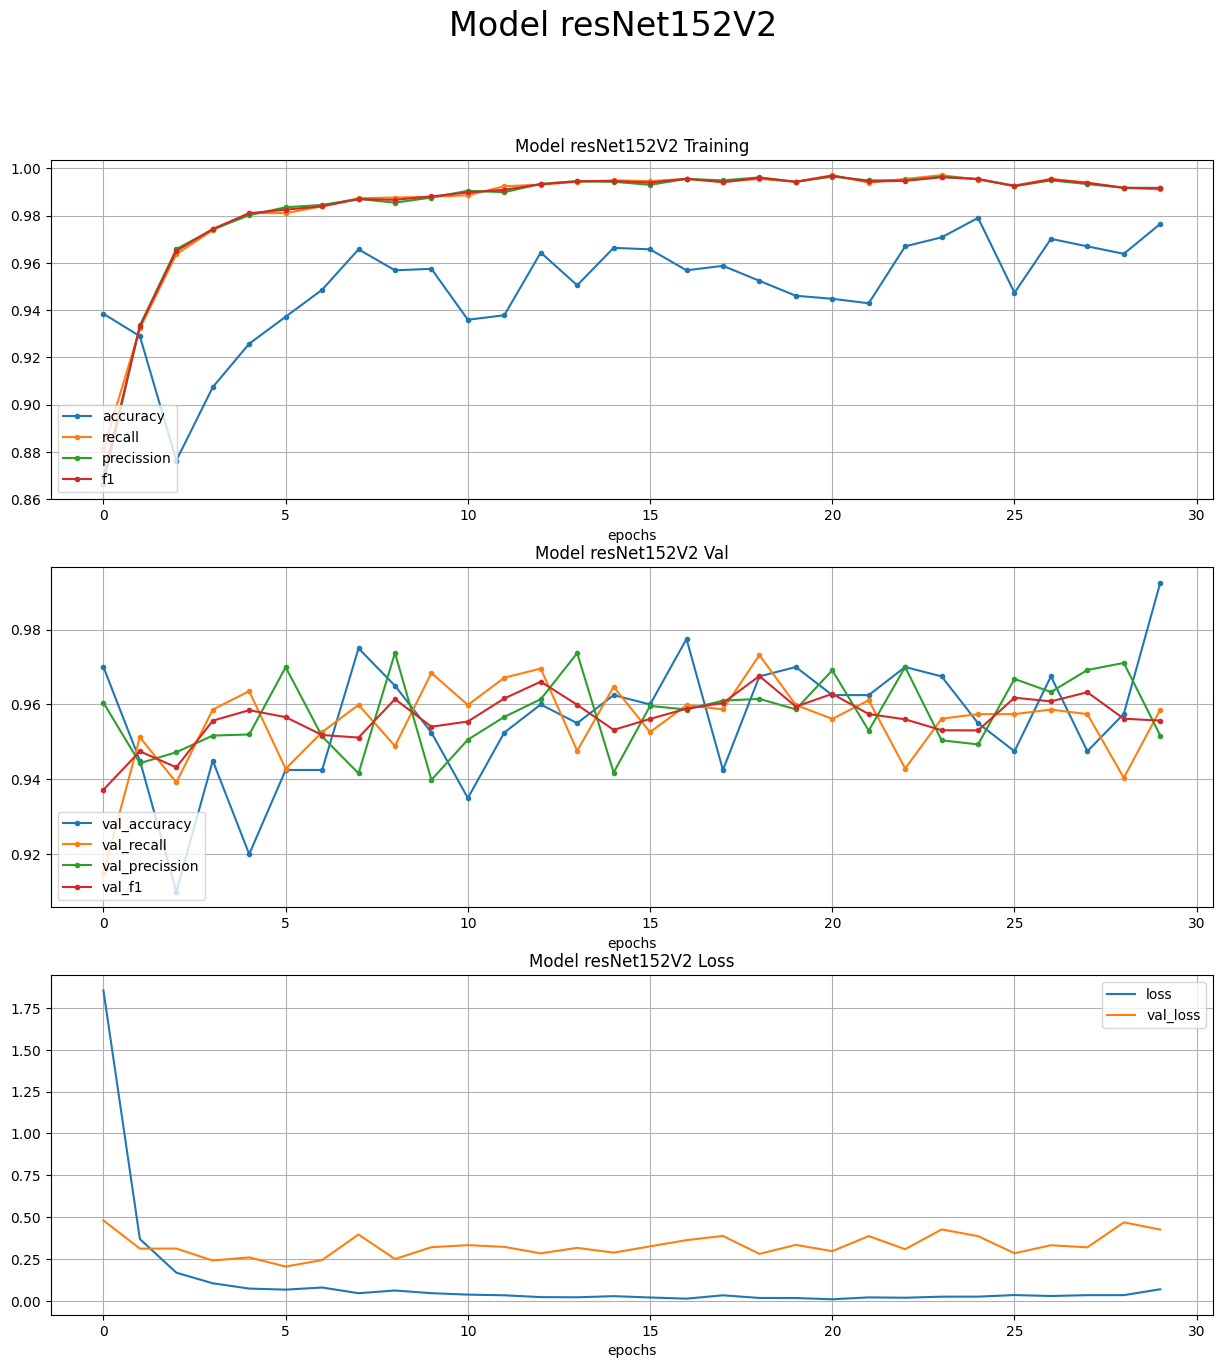

In [61]:
plot_model(histori4, "Model resNet152V2")

In [62]:
model_resNet152V2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 4s 40ms/step - loss: 0.5058 - accuracy: 0.9906 - recall: 0.9623 - precision: 0.9401 - f1_score: 0.9524


[0.5058338642120361,
 0.9905660152435303,
 0.9622641801834106,
 0.940092146396637,
 0.9524259567260742]

In [63]:
predict(model_resNet152V2, "model resNet152V2.csv")

106/106 [==============================] - 6s 37ms/step


In [64]:
dt_predict_resnet152V2 = pd.read_csv("model resNet152V2.csv")

In [65]:
y_pred_resnet152V2 = dt_predict_resnet152V2[classes]

[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 25   6]
  [  2  73]]

 [[ 96   1]
  [  1   8]]

 [[ 83   5]
  [  5  13]]]


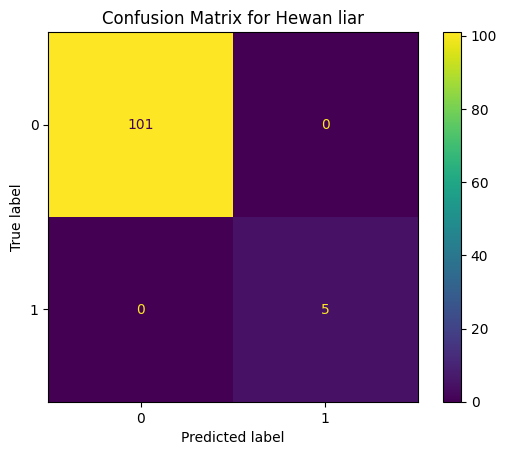

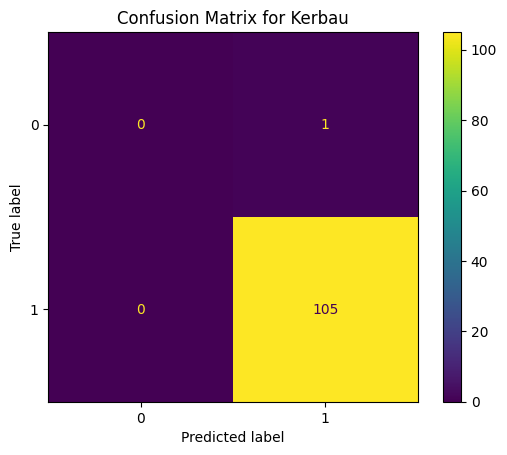

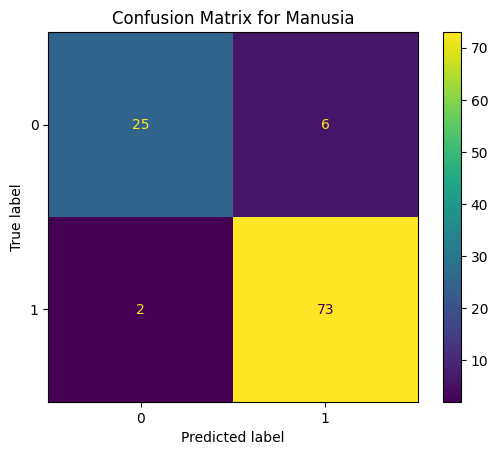

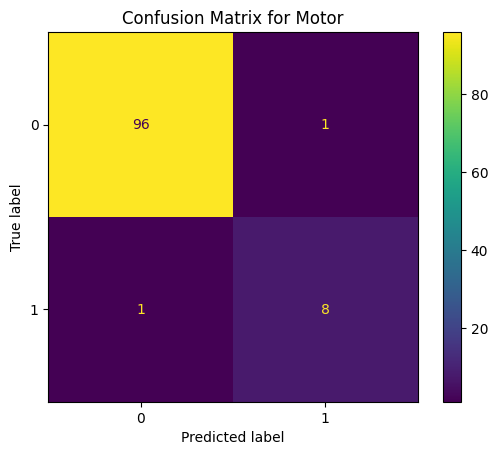

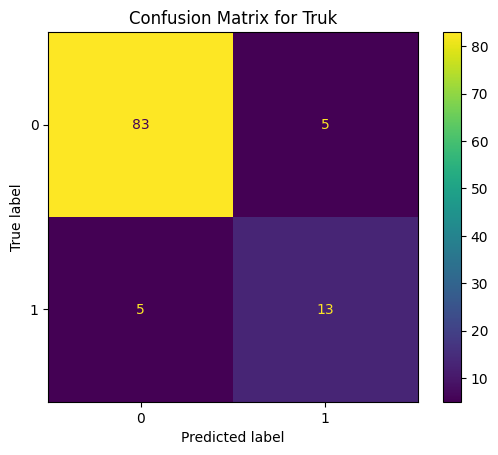

In [66]:
visaul_confusion_matrix(y_true, y_pred_resnet152V2)

### Xception

In [67]:
def Xception():
    pre_trainded_model = tf.keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                                 include_top=False,
                                                                 weights='imagenet')
    
    for layer in pre_trainded_model.layers:
        layer.trainable = False
        
    return pre_trainded_model

In [68]:
xception = Xception()
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [69]:
last_layer_xception = xception.get_layer("block14_sepconv2_act")
last_output_exception = last_layer_xception.output

In [70]:
model_xception = model(xception, last_output_exception)
model_xception.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_xception.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [71]:
with tf.device("/device:GPU:0"):
    histori5 = model_xception.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_xception")])

Epoch 1/30
50/50 [==============================] - 7s 81ms/step - loss: 1.7166 - accuracy: 0.9137 - recall: 0.8554 - precision: 0.8429 - f1_score: 0.8431 - val_loss: 0.2924 - val_accuracy: 0.9000 - val_recall: 0.8295 - val_precision: 0.9592 - val_f1_score: 0.8891
Epoch 2/30
50/50 [==============================] - 3s 65ms/step - loss: 0.2143 - accuracy: 0.9036 - recall: 0.8941 - precision: 0.9145 - f1_score: 0.9036 - val_loss: 0.1567 - val_accuracy: 0.9375 - val_recall: 0.9380 - val_precision: 0.9180 - val_f1_score: 0.9277
Epoch 3/30
50/50 [==============================] - 3s 62ms/step - loss: 0.1452 - accuracy: 0.9124 - recall: 0.9297 - precision: 0.9320 - f1_score: 0.9306 - val_loss: 0.1767 - val_accuracy: 0.9400 - val_recall: 0.9148 - val_precision: 0.9353 - val_f1_score: 0.9252
Epoch 4/30
50/50 [==============================] - 3s 65ms/step - loss: 0.1135 - accuracy: 0.9378 - recall: 0.9454 - precision: 0.9481 - f1_score: 0.9466 - val_loss: 0.1760 - val_accuracy: 0.9400 - val_re

<function matplotlib.pyplot.show(close=None, block=None)>

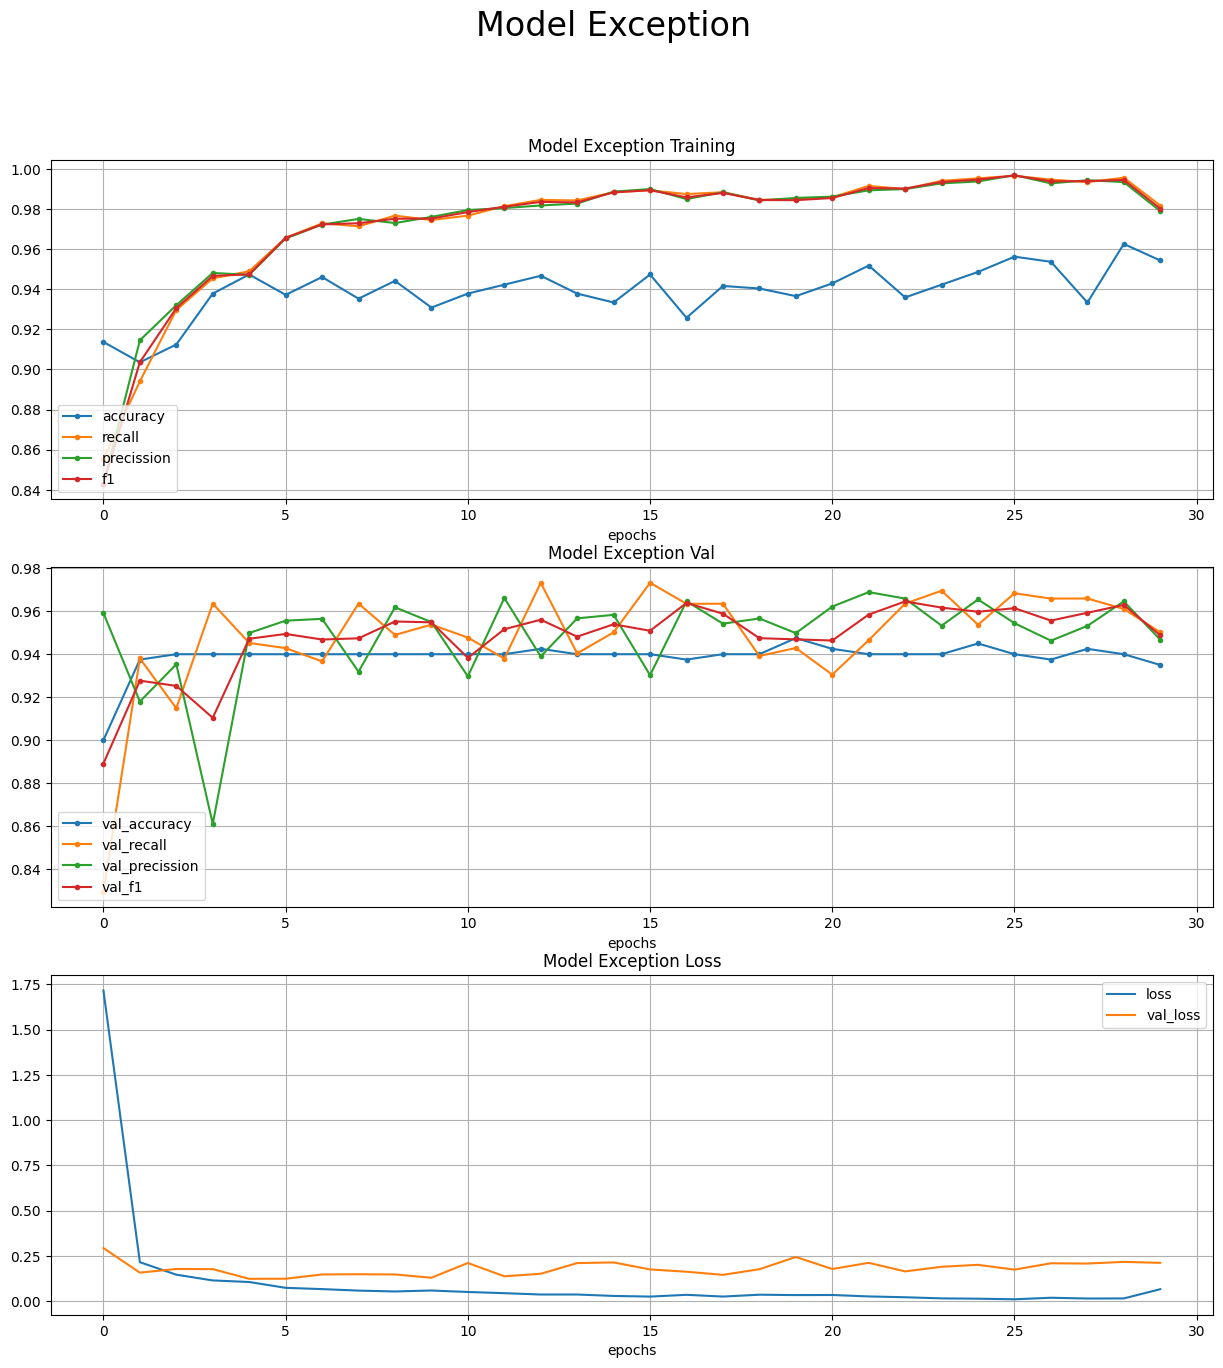

In [72]:
plot_model(histori5, "Model Exception")

In [73]:
model_xception.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 1s 13ms/step - loss: 0.2237 - accuracy: 0.9434 - recall: 0.9575 - precision: 0.9442 - f1_score: 0.9519


[0.22374705970287323,
 0.9433962106704712,
 0.9575471878051758,
 0.9441860318183899,
 0.9518868327140808]

### Inception ResnetV2

In [75]:
def inception_resnetv2():
    pre_trainded_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        input_shape = (224, 224, 3),
        include_top = False,
        weights='imagenet'
    )
    
    for layer in pre_trainded_model.layers:
        layer.trainable = False
        
    return pre_trainded_model

In [76]:
inception_resnetv2 = inception_resnetv2()
inception_resnetv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                               

In [77]:
last_layer_inresnetv2 = inception_resnetv2.get_layer("conv_7b_ac")
last_output_inresnetv2 = last_layer_inresnetv2.output


In [78]:
model_inception_resnetv2 = model(inception_resnetv2, last_output_inresnetv2)
model_inception_resnetv2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)

In [79]:
model_inception_resnetv2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

In [80]:
with tf.device("/device:GPU:0"):
    histori6 = model_inception_resnetv2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_inception_resnetv2")])

Epoch 1/30
50/50 [==============================] - 18s 168ms/step - loss: 1.5440 - accuracy: 0.9093 - recall: 0.8274 - precision: 0.8128 - f1_score: 0.8127 - val_loss: 0.2395 - val_accuracy: 0.9400 - val_recall: 0.8457 - val_precision: 0.8969 - val_f1_score: 0.8705
Epoch 2/30
50/50 [==============================] - 5s 101ms/step - loss: 0.2614 - accuracy: 0.9105 - recall: 0.8676 - precision: 0.8789 - f1_score: 0.8734 - val_loss: 0.1787 - val_accuracy: 0.9325 - val_recall: 0.9088 - val_precision: 0.9077 - val_f1_score: 0.9088
Epoch 3/30
50/50 [==============================] - 5s 102ms/step - loss: 0.2039 - accuracy: 0.9181 - recall: 0.8890 - precision: 0.9068 - f1_score: 0.8971 - val_loss: 0.2019 - val_accuracy: 0.9225 - val_recall: 0.9526 - val_precision: 0.8828 - val_f1_score: 0.9163
Epoch 4/30
50/50 [==============================] - 5s 101ms/step - loss: 0.2003 - accuracy: 0.9391 - recall: 0.8845 - precision: 0.9169 - f1_score: 0.8990 - val_loss: 0.1675 - val_accuracy: 0.9400 - v

<function matplotlib.pyplot.show(close=None, block=None)>

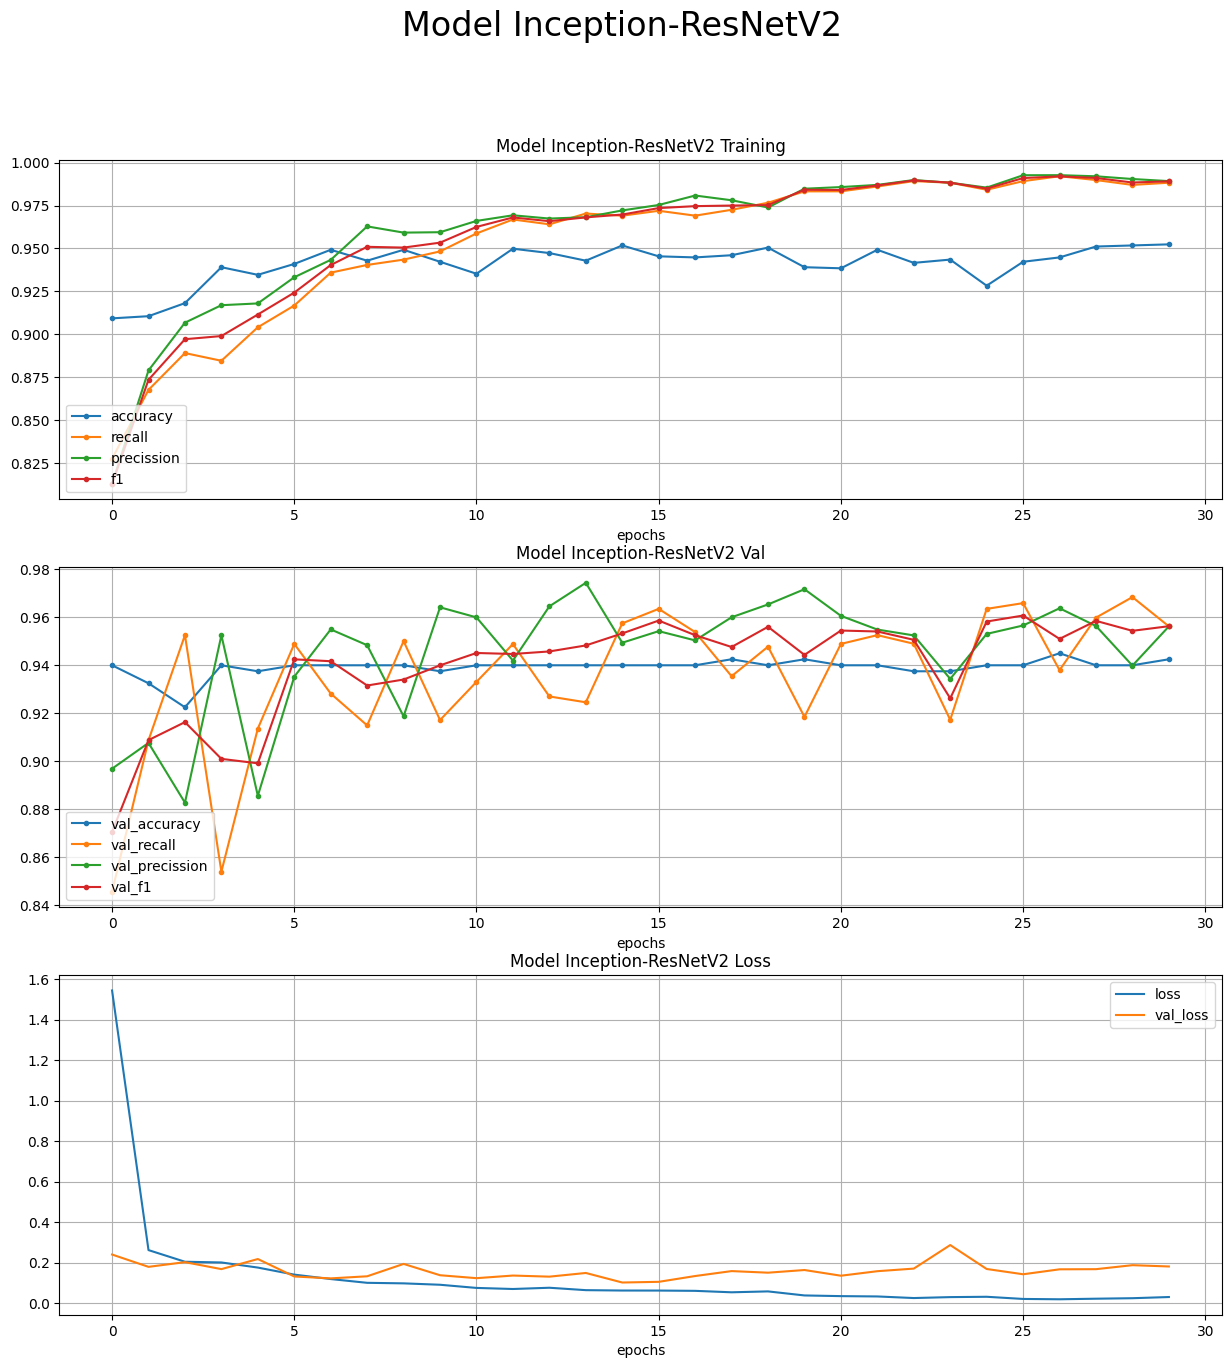

In [81]:
plot_model(histori6, "Model Inception-ResNetV2")

In [82]:
model_inception_resnetv2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 5s 49ms/step - loss: 0.2284 - accuracy: 0.9434 - recall: 0.9481 - precision: 0.9571 - f1_score: 0.9543


[0.2284041941165924,
 0.9433962106704712,
 0.948113203048706,
 0.9571428298950195,
 0.9543126821517944]

In [83]:
predict(model_inception_resnetv2, "model_inception_resnetv2.csv")
dt_model_inresnetv2 = pd.read_csv("model_inception_resnetv2.csv")
y_pred_inresnetv2 = dt_model_inresnetv2[classes]

106/106 [==============================] - 8s 48ms/step


[[[101   0]
  [  1   4]]

 [[  0   1]
  [  0 105]]

 [[ 25   6]
  [  2  73]]

 [[ 96   1]
  [  2   7]]

 [[ 87   1]
  [  6  12]]]


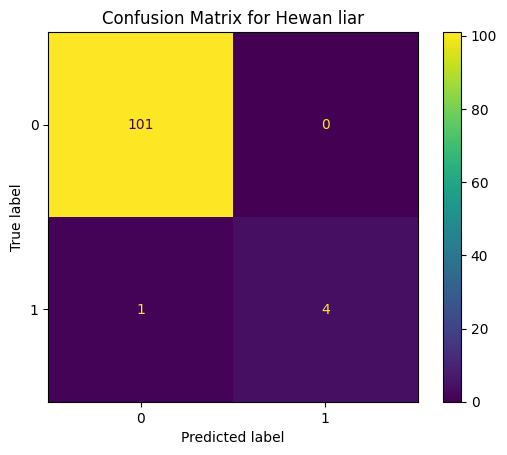

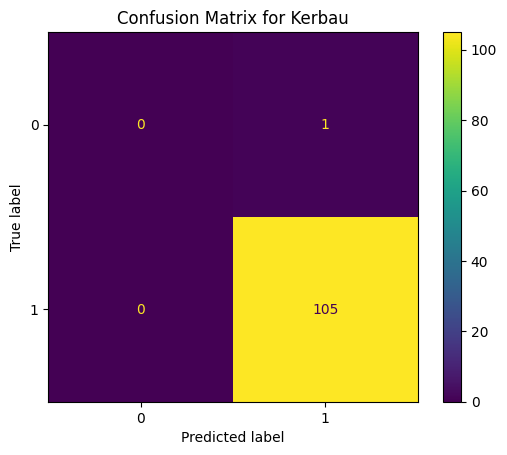

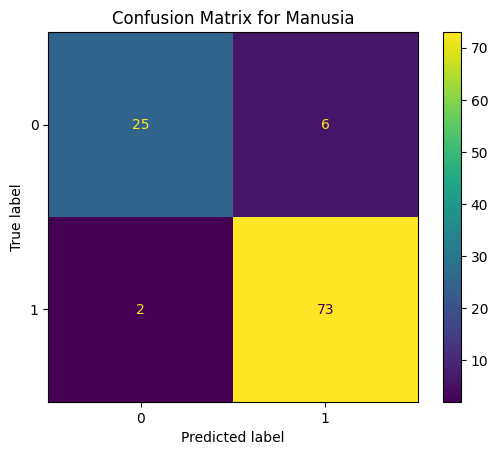

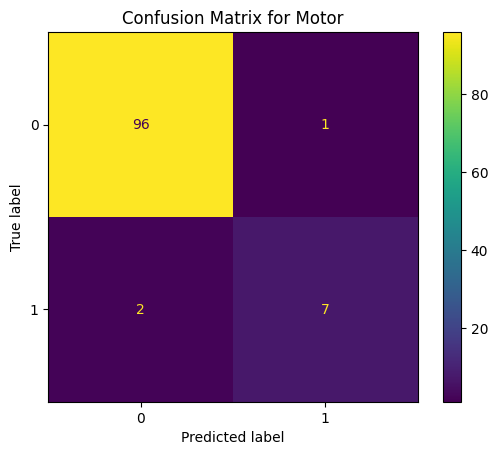

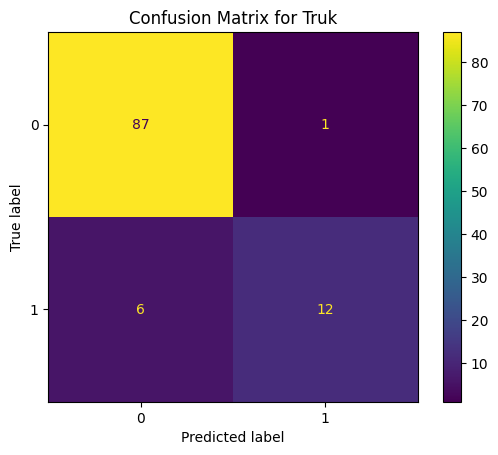

In [84]:
visaul_confusion_matrix(y_true, y_pred_inresnetv2)

### EfficienNet

In [85]:
def efficienNetV2S():
    pre_trained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    return pre_trained_model

In [86]:
efficienNetV2S = efficienNetV2S()
efficienNetV2S.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [87]:
last_layer_efficientNetV2S = efficienNetV2S.get_layer("top_activation")
last_output_efficientNetV2S = last_layer_efficientNetV2S.output

In [88]:
model_efficienNetV2S = model(efficienNetV2S, last_output_efficientNetV2S)
model_efficienNetV2S.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)

In [89]:
model_efficienNetV2S.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

In [90]:
with tf.device("/device:GPU:0"):
    histori7 = model_efficienNetV2S.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_efficienNetV2S")])

Epoch 1/30
50/50 [==============================] - 19s 155ms/step - loss: 2.4294 - accuracy: 0.9270 - recall: 0.8011 - precision: 0.8148 - f1_score: 0.7975 - val_loss: 0.3196 - val_accuracy: 0.9400 - val_recall: 0.8090 - val_precision: 0.8902 - val_f1_score: 0.8477
Epoch 2/30
50/50 [==============================] - 5s 93ms/step - loss: 0.3494 - accuracy: 0.9131 - recall: 0.8183 - precision: 0.8620 - f1_score: 0.8365 - val_loss: 0.3137 - val_accuracy: 0.9400 - val_recall: 0.8504 - val_precision: 0.8705 - val_f1_score: 0.8601
Epoch 3/30
50/50 [==============================] - 5s 91ms/step - loss: 0.3118 - accuracy: 0.9505 - recall: 0.8378 - precision: 0.8603 - f1_score: 0.8473 - val_loss: 0.2985 - val_accuracy: 0.9400 - val_recall: 0.8528 - val_precision: 0.8686 - val_f1_score: 0.8604
Epoch 4/30
50/50 [==============================] - 5s 90ms/step - loss: 0.2924 - accuracy: 0.9480 - recall: 0.8404 - precision: 0.8749 - f1_score: 0.8570 - val_loss: 0.2699 - val_accuracy: 0.9400 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

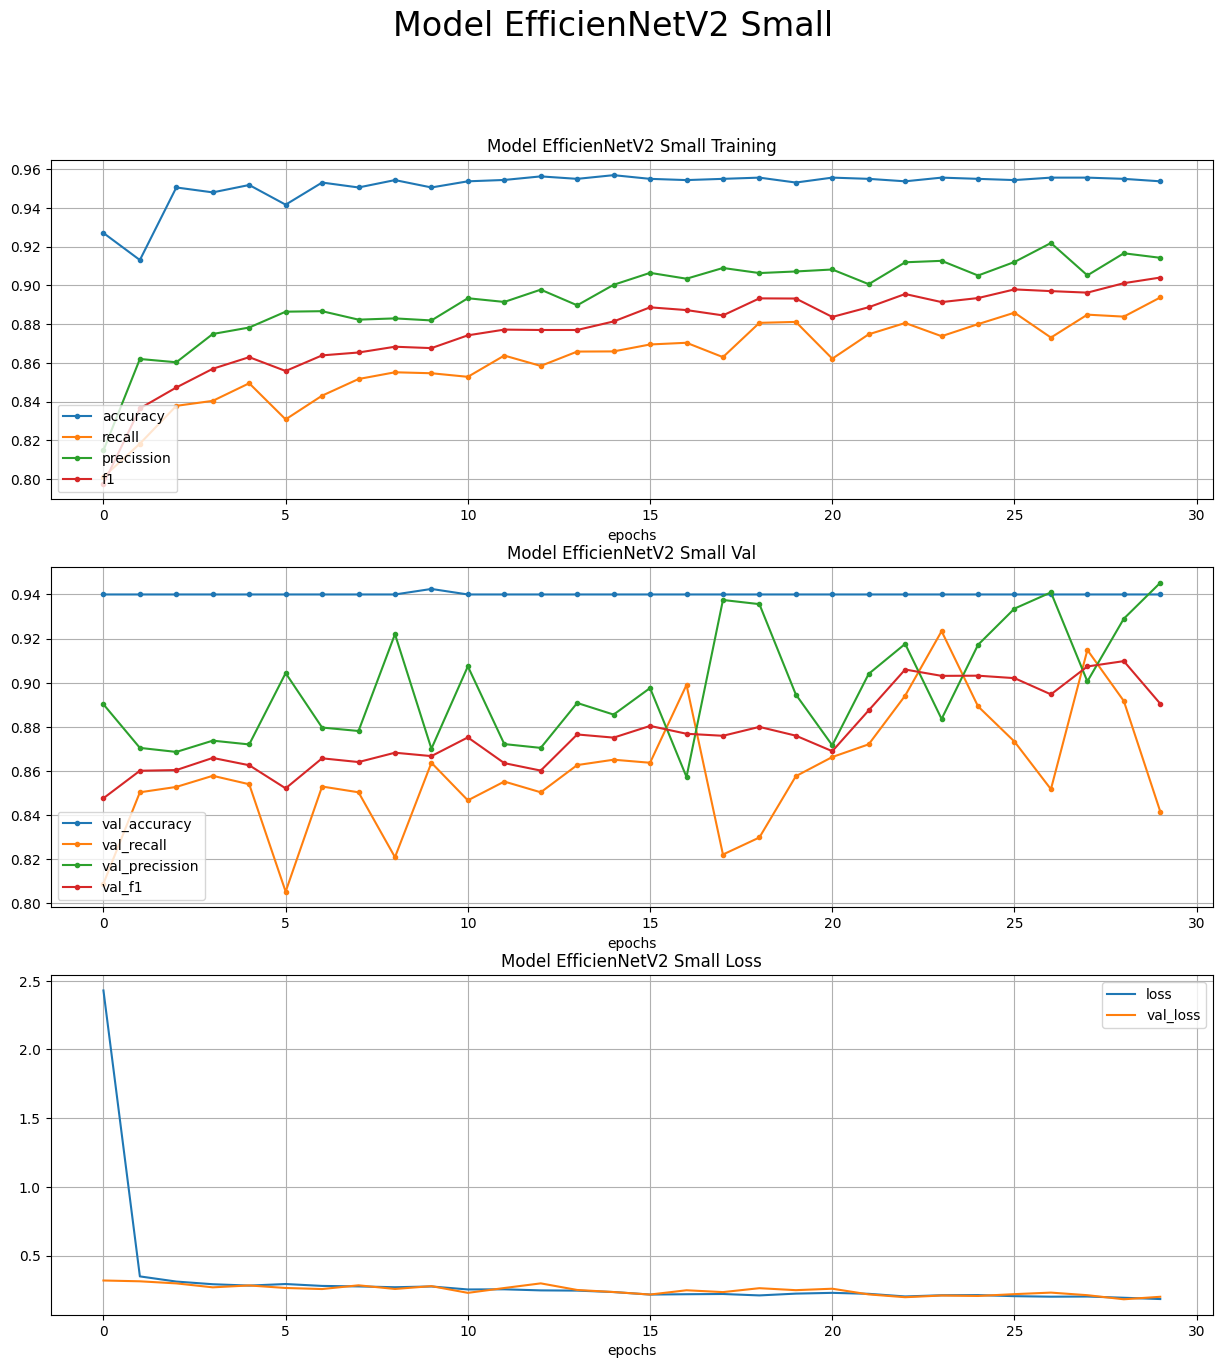

In [91]:
plot_model(histori7, "Model EfficienNetV2 Small")

In [92]:
model_efficienNetV2S.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 5s 44ms/step - loss: 0.1944 - accuracy: 0.9434 - recall: 0.8491 - precision: 0.9474 - f1_score: 0.9041


[0.19444066286087036,
 0.9433962106704712,
 0.849056601524353,
 0.9473684430122375,
 0.9040881395339966]

In [93]:
predict(model_efficienNetV2S, 'model efficienNet.csv')

106/106 [==============================] - 8s 52ms/step


In [94]:
dt_model_efficenNetV2S = pd.read_csv('model efficienNet.csv')

In [95]:
y_pred_efficenNetV2S = dt_model_efficenNetV2S[classes]

[[[101   0]
  [  1   4]]

 [[  0   1]
  [  0 105]]

 [[ 23   8]
  [  7  68]]

 [[ 96   1]
  [  7   2]]

 [[ 88   0]
  [ 17   1]]]


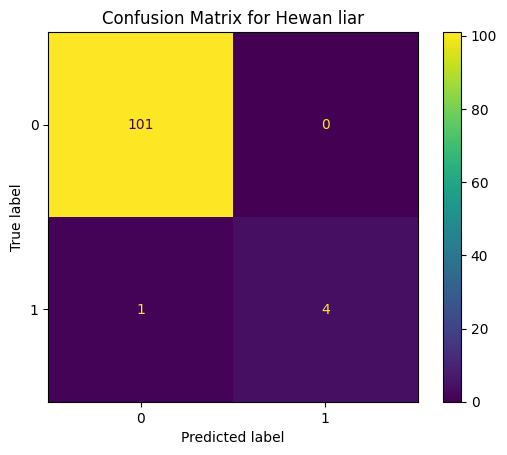

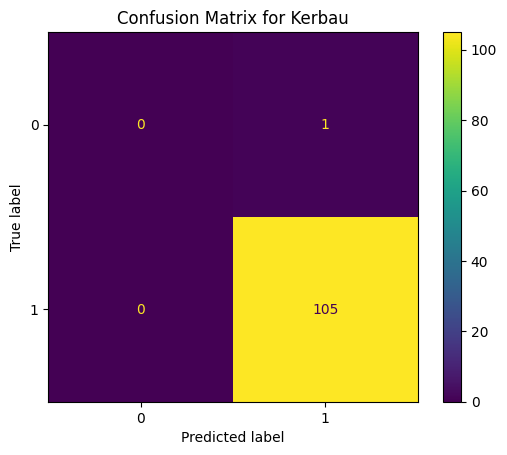

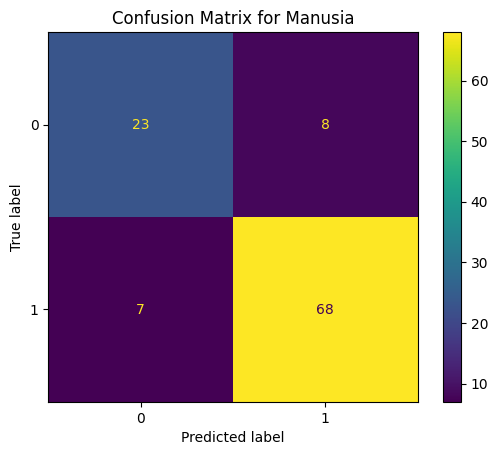

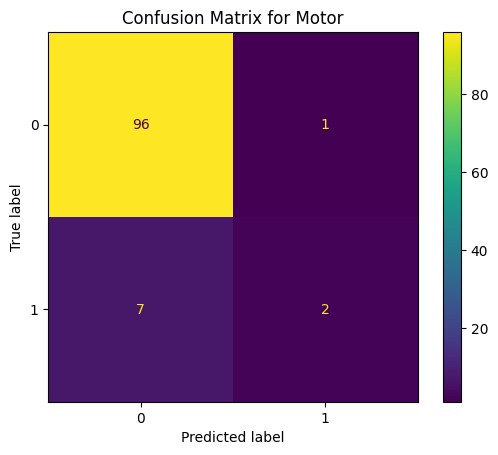

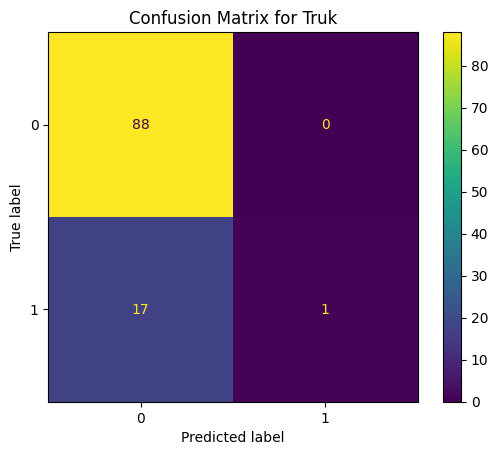

In [96]:
visaul_confusion_matrix(y_true, y_pred_efficenNetV2S)

# Define Vis Model

In [ ]:
def layer_name(model):
    outputs = [layer.outputs for layer in model.layer]
    layer_name = []
    for layer in outputs:
        layer_name.append(layer.name.split("/"))
    
    return layer_name

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

In [ ]:
predict()

In [ ]:
visaul_confusion_matrix()

### Define Grad Cam

In [ ]:
def get_img_array(dir, size):
    img = keras.utils.load_img(dir, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))